In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num, num2date
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob
import sklearn as skl
from sklearn.utils.extmath import randomized_svd
#import dask
from matplotlib import style


In [3]:
def my_svd(data, tname='time', uname='u', vname='v', spacename='z', tresh=0.90,plot=False):
    u_mean=data[uname].mean(dim=tname)
    v_mean=data[uname].mean(dim=tname)
    uu=(data[uname]-u_mean).where(data.land_binary_mask==0).dropna(dim=spacename).data
    vv=(data[vname]-v_mean).where(data.land_binary_mask==0).dropna(dim=spacename).data
    
    C=np.dot(uu.T, vv)
    U,L,Vh = np.linalg.svd(C)
    
    V=Vh.T
    SCF=L/np.sum(L)
    indx=int(np.argwhere(np.cumsum(SCF)>tresh)[0])+1
    

    U=U[:,0:indx]
    V=V[:,0:indx]
    L=L[0:indx]
    SCF=SCF[0:indx]
    A=uu@U
    B=vv@V
    
    re_U=A@U.T
    re_V=B@V.T
    if plot:
        plt.plot(SCF)
        plt.xlim(0,10)
        plt.plot(np.cumsum(SCF))
    print(A.shape)
    out=data.copy()
    out['u_pcs']=((tname,'mode'),A)
    out['v_pcs']=((tname,'mode'),B)
    out['u_eofs']=((u_mean.dims + ('mode',)),U)
    out['v_eofs']=((v_mean.dims + ('mode',)),V)
    out['eigen']=(('mode'),L)
    out['SCF']=(('mode'),SCF)

    return out

def my_svd_randomized(data, tname='time', uname='u', vname='v', spacename=['Y','X'], N=20,plot=False,random_state=10):
    tmp=data.stack(z=spacename)
    tmp=tmp.where(tmp.land_binary_mask==0).dropna(dim='z')
    u_mean=tmp[uname].mean(dim=tname)
    v_mean=tmp[vname].mean(dim=tname)
    uu=(tmp[uname]-u_mean).data # Need a warning here. Will alter the calculations. 
    vv=(tmp[vname]-v_mean).data
    
    C=np.dot(uu.T, vv)
    
    U,L,Vh = randomized_svd(C,N,random_state=random_state)
    
    V=Vh.T

    A=uu@U
    B=vv@V
    
    #re_U=A@U.T
    #re_V=B@V.T
    #if plot:
    #    plt.plot(L)
        
    
    #out['u_mean']=u_mean
    #out['v_mean']=v_mean
    tmp=xr.Dataset(coords=tmp.coords)
    tmp[uname+'_eigen']=(('mode'),L)
    tmp[uname+'_pcs']=((tname,'mode'),A)
    tmp[vname+'_pcs']=((tname,'mode'),B)
    tmp[uname+'_eofs']=((u_mean.dims + ('mode',)),U,compat='override')
    tmp[vname+'_eofs']=((v_mean.dims + ('mode',)),V,compat='override')
    
    
    
    #out['speed']=np.sqrt(out.u**2+out.v**2)
    #angles=np.arctan2(out['v'],out['u'])
    #out['direction']=(angles + 2 * np.pi) % (2 * np.pi)*(180/np.pi)
    #out=data.copy()
    return xr.merge([data,tmp.unstack('z')])

def my_tide(data,tname='time',lat=60, uname='u',vname='v', roll=5):
    
    data['tide_u']=data[uname]*0
    data['tide_v']=data[vname]*0
    time=date2num(data.time.to_pandas().index)

    for ii in np.arange(len(data['z'])):
        tmp=data.isel(z=ii)
        uu=tmp[uname].rolling(time=roll).mean().data
        vv=tmp[vname].rolling(time=roll).mean().data
        coef = solve(time, uu, vv, lat=lat,verbose=False)
        tide = reconstruct(date2num(data.time), coef,verbose=False)
        data['tide_u'][:,ii]=tide.u
        data['tide_v'][:,ii]=tide.v

    data['res_u']=data[uname]-data['tide_u']
    data['res_v']=data[vname]-data['tide_v']

    return data
    

SyntaxError: invalid syntax (2600901029.py, line 68)

In [4]:
def eofs_GA(inxarr, variables=['u','v'], neofs=10, time_name='time', npcs=5, treshold=None):
    tmp=inxarr[variables]
    tmp=tmp.to_stacked_array('z_loc',sample_dims=[time_name]).fillna(0)
    solver = Eof(tmp)
 
    out=solver.eofs(neofs=neofs).to_unstacked_dataset('z_loc').unstack()
    #xr.Dataset()
    out['X']=inxarr['X']
    out['Y']=inxarr['Y']
    out['time']=inxarr['time']
    out['eigenvals']=solver.eigenvalues()
    out['land_binary_mask']=inxarr['land_binary_mask']
    #if treshold < lmbda.mode.max(): 
    #    np.searchsorted(lmbda.cumsum()/lmbda.sum(),[0.9,],side='right')[0]
    # eofs=solver.eofs(neofs=5).to_unstacked_dataset('z_loc').unstack()
    # out['eofs_u']=eofs['u']
    # out['eofs_v']=eofs['v']
    out['speed']=np.sqrt(out.u**2+out.v**2)
    angles=np.arctan2(out['v'],out['u'])
    out['direction']=(angles + 2 * np.pi) % (2 * np.pi)*(180/np.pi)
    out['pcs']=solver.pcs(npcs=npcs)

    return out

    


In [5]:
##NOT working
def plot_eofs(res,name='',save_dir='',save=False):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.7)
    fig.suptitle("Eofs" + name, fontsize=18, y=0.95)
    axes=axs.ravel()
    res.eigen.isel(mode=[0,1,2,3]).plot.line(x='time',ax=axes[0])
    
    for mode in np.arange(4):
        res.isel(mode=mode).where(res.land_binary_mask==0).plot.quiver(x='X',y='Y' ,u='u', v='v',hue='u',ax=axes[mode+2])

    if save:
        plt.savefig(save_dir+name+'.jpg')

In [7]:
data=xr.open_dataset('Data/byfjordenSubset.nc')
data.close()


In [23]:
def my_mask(inarr):
    inarr['umean']=inarr.u.mean(dim='time')
    inarr['vmean']=inarr.v.mean(dim='time')
    inarr['ustd']=inarr.u.std(dim='time')
    inarr['vstd']=inarr.v.std(dim='time')
    inarr=inarr.stack(z=['Y','X'])
    inarr=inarr.where(inarr.land_binary_mask==0,drop=True).dropna(dim='z')
    inarr['ucent']=(inarr.u-inarr.umean)
    inarr['unorm']=inarr.ucent/(1e-9+inarr.ustd)
    inarr['vcent']=(inarr.v-inarr.vmean)
    inarr['vnorm']=inarr.vcent/(1e-9+inarr.vstd)
    return inarr

In [97]:
focus=data.sel(Y=slice(6733400,6737500),X=slice(-40000,-35000)).isel(depth=0)
focus['u']=focus.u.interpolate_na(dim='time')
focus['v']=focus.v.interpolate_na(dim='time')
coarse=focus.isel(Y=slice(0,focus.dims['Y'],4),X=slice(0,focus.dims['X'],4))
focus

<xarray.Dataset>
Dimensions:           (time: 1501, Y: 82, X: 100)
Coordinates:
  * X                 (X) float32 -3.999e+04 -3.994e+04 ... -3.504e+04
  * Y                 (Y) float32 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.007282 -0.001192
    v                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.2895 -0.2954
    h                 (Y, X) float32 ...
    projection_stere  float32 ...
    land_binary_mask  (Y, X) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [99]:

coarse=my_mask(coarse)
focus=my_mask(focus)

In [100]:
focus

<xarray.Dataset>
Dimensions:           (time: 1501, z: 3495)
Coordinates:
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
  * z                 (z) MultiIndex
  - Y                 (z) float64 6.734e+06 6.734e+06 ... 6.737e+06 6.737e+06
  - X                 (z) float64 -3.959e+04 -3.954e+04 ... -3.504e+04
Data variables: (12/13)
    u                 (time, z) float32 -0.00111 -0.000812 ... -0.001192
    v                 (time, z) float32 0.00219 0.002961 ... -0.2895 -0.2954
    h                 (z) float32 8.383 7.588 6.183 6.31 ... 151.3 174.5 197.2
    projection_stere  (z) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    land_binary_mask  (z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    umean             (z) float32 0.0005804 0.0008301 ... -0.008731 -0.008984
    ...                ...
    ustd              (z) float32 0.003387 0.003407 0.003581 ... 0.02947 0.03013
    vstd              (z) float32 0.003928 0.003602 0.004586 ... 0.07496 0.07305
    ucent             (time, z) float32 -0.00169 -0.001642 ... 0.001449 0.007792
    unorm             (time, z) float32 -0.4989 -0.4819 ... 0.04917 0.2586
    vcent             (time, z) float32 0.002451 0.002367 ... -0.2541 -0.2589
    vnorm             (time, z) float32 0.6239 0.6572 0.723 ... -3.39 -3.544
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [135]:
u=focus.ucent.data+focus.vcent.data*1j
v=coarse.ucent.data+coarse.vcent.data*1j
U,L,Vt=np.linalg.svd(np.transpose(u)@v)

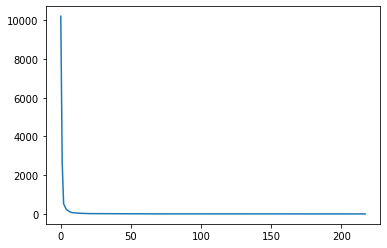

In [136]:
plt.plot(L)

In [137]:
modes=20
U=U[:,0:modes]
V=Vt.T[:,0:modes]
L=L[0:modes]

In [161]:
B=coarse.ucent.data@V
uc=xr.DataArray(B@np.transpose(V),coords=coarse.v.coords)
A=np.linalg.pinv(B).T@np.diag(L)
uu=xr.DataArray(A@U.T,coords=focus.u.coords)


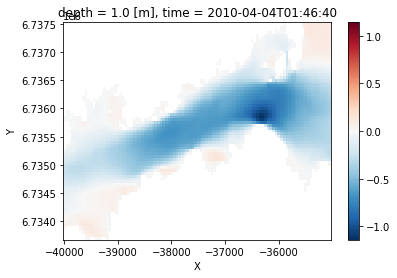

In [162]:
uu.isel(time=100).imag.unstack('z').plot()

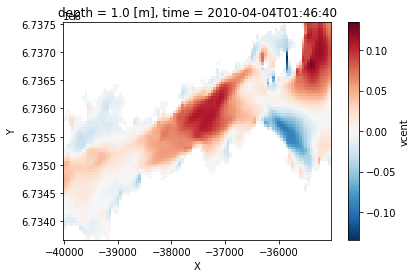

In [160]:
focus.vcent.isel(time=100).unstack('z').plot()

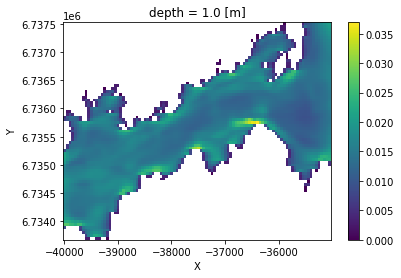

In [82]:
(u-uu).std(dim='time').unstack('z').plot()

In [83]:
uf6=focus.sel(time=slice('2010-6','2010-6'))
tmp=coarse.sel(time=slice('2010-6','2010-6'))
u6=(tmp.u-coarse.umean)#/(1.e-9+coarse.ustd)
u6


<xarray.DataArray (time: 405, z: 218)>
array([[ 0.00882587, -0.01594416, -0.01206522, ...,  0.02247139,
         0.00570424,  0.01898352],
       [-0.00060653, -0.02742487, -0.02000223, ...,  0.01996199,
         0.00053636,  0.01842131],
       [-0.02934441, -0.03164529, -0.02882287, ..., -0.02015133,
        -0.00660442, -0.00650485],
       ...,
       [ 0.00358287, -0.00044646,  0.00907476, ...,  0.00297267,
         0.00121714, -0.00614425],
       [ 0.00295337, -0.02085035, -0.00843813, ...,  0.01762401,
        -0.0035927 ,  0.00681591],
       [ 0.0022087 , -0.01060324, -0.03152736, ...,  0.01718531,
        -0.00448435,  0.00276396]], dtype=float32)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-06-01 ... 2010-06-30T22:13:20
  * z        (z) MultiIndex
  - Y        (z) float64 6.734e+06 6.734e+06 6.734e+06 ... 6.737e+06 6.737e+06
  - X        (z) float64 -3.959e+04 -3.939e+04 ... -3.539e+04 -3.519e+04

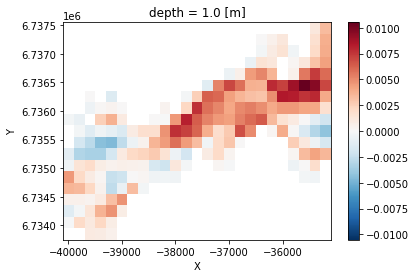

In [84]:
u6.mean(dim='time').unstack('z').plot()

In [85]:

B6=u6.data@V
#uc6=xr.DataArray(B@V.T,coords=u6.coords)
A6=np.linalg.pinv(B6).T@np.diag(L) #np.linalg.pinv(B6).T@np.diag(L)
print(np.shape(A6))
uu6=xr.DataArray(A6@U.T,coords=uf6.coords)

(405, 20)


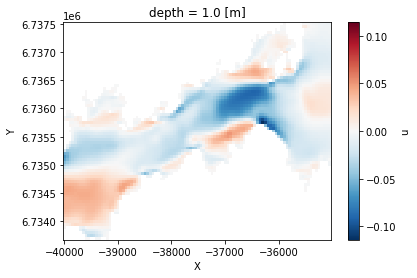

In [86]:
uf6.u.mean(dim='time').unstack('z').plot()

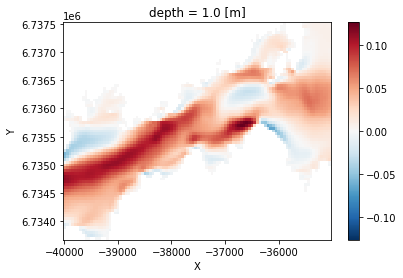

In [89]:
(uu6+focus.umean).mean(dim='time').unstack('z').plot()

In [147]:
u1=uu.sel(time=slice('2010-2','2010-5'))
v1=vv.sel(time=slice('2010-2','2010-5'))
u1,l1,v1t=np.linalg.svd(u1.data.T@v1.data)

In [165]:
uu.mean(dim='time')

<xarray.DataArray 'u' (z: 8200)>
array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -2.0874491e-05, -2.5157766e-05, -2.8489432e-05], dtype=float32)
Coordinates:
    depth    float32 1.0
  * z        (z) MultiIndex
  - Y        (z) float64 6.733e+06 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
  - X        (z) float64 -3.999e+04 -3.994e+04 ... -3.509e+04 -3.504e+04

(0.0, 10.0)

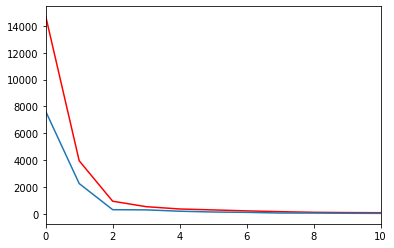

In [174]:
plt.plot(l,'r')
plt.plot(l1)
plt.xlim(0,10)

(0.0, 20.0)

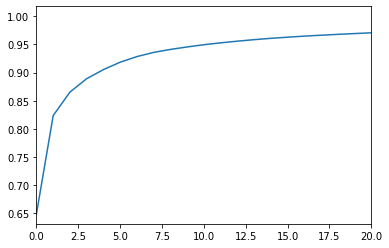

In [20]:
plt.plot(l.cumsum()/l.sum())
plt.xlim(0,20)

In [148]:
modes=300
UU=u1[:,0:modes]
VV=v1t.T[:,0:modes]
A=uu.data@UU
u_res=xr.DataArray(A@UU.T,coords=uu.coords)
B=vv.data@VV
BB=np.linalg.pinv(A.T)@np.diag(l1[0:modes])
v_res=xr.DataArray(B@VV.T,coords=vv.coords)
v_est=xr.DataArray(BB@VV.T,coords=vv.coords)

In [149]:
np.shape(l[0:modes]/B.mean(axis=0))

(300,)

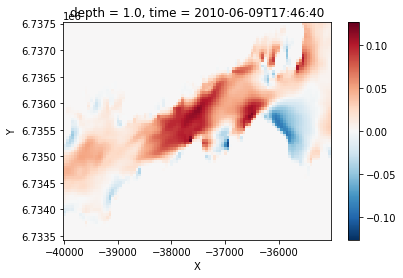

In [150]:
v_res.unstack('z').isel(time=1000).plot()

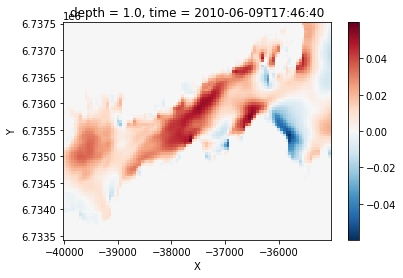

In [151]:
v_est.unstack('z').isel(time=1000).plot()

In [152]:
uj=uu.sel(time=slice('2010-6','2010-6'))
vj=vv.sel(time=slice('2010-6','2010-6'))
Aj=uj.data@UU
uj_res=xr.DataArray(Aj@UU.T,coords=uj.coords)
Bj=vj.data@VV
BBj=np.linalg.pinv(Aj.T)@np.diag(l1[0:modes])
vj_res=xr.DataArray(Bj@VV.T,coords=vj.coords)
vj_est=xr.DataArray(BBj@VV.T,coords=vj.coords)


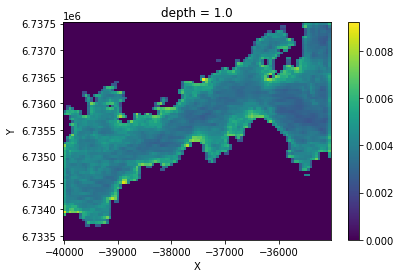

In [153]:
(uj-uj_res).unstack('z').std(dim='time').plot()

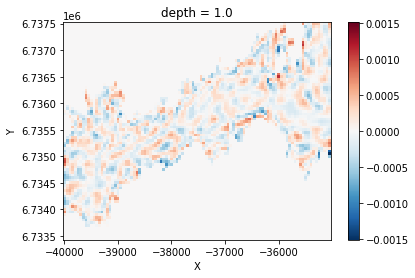

In [154]:
(vj-vj_res).unstack('z').mean(dim='time').plot()

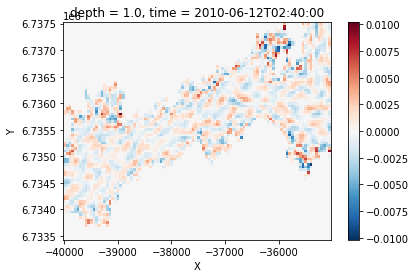

In [145]:
(vj-vj_res).unstack('z').isel(time=150).plot()

## coarse to fine


In [177]:
focus

<xarray.Dataset>
Dimensions:           (time: 1501, Y: 82, X: 100)
Coordinates:
  * X                 (X) float32 -3.999e+04 -3.994e+04 ... -3.504e+04
  * Y                 (Y) float32 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.007282 -0.001192
    v                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.2895 -0.2954
    h                 (Y, X) float32 0.0 0.0 0.0 0.0 ... 127.2 151.3 174.5 197.2
    projection_stere  float32 9.969e+36
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [278]:

focus=focus
uu=(focus.u-focus.u.mean(dim='time')).stack(z=['Y','X']).interpolate_na(dim='time')
tmp=focus.isel(Y=slice(0,82,4),X=slice(0,100,4))
vv=(tmp.u-tmp.u.mean(dim='time')).stack(z=['Y','X']).interpolate_na(dim='time')

u1=uu.sel(time=slice('2010-2','2010-5'))
v1=vv.sel(time=slice('2010-2','2010-5'))
u2,l2,v2t=np.linalg.svd(u1.data.T@v1.data)

In [286]:
v2t@v2t.T

array([[ 1.0000000e+00,  0.0000000e+00, -1.1175871e-08, ...,
         0.0000000e+00,  0.0000000e+00,  2.9360703e-17],
       [ 0.0000000e+00,  1.0000000e+00,  2.9802322e-08, ...,
         0.0000000e+00,  0.0000000e+00,  4.6741184e-17],
       [-1.1175871e-08,  2.9802322e-08,  1.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  6.2173065e-17],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  9.9999994e-01,  0.0000000e+00],
       [ 2.9360703e-17,  4.6741184e-17,  6.2173065e-17, ...,
         0.0000000e+00,  0.0000000e+00,  9.9999994e-01]], dtype=float32)

(0.0, 10.0)

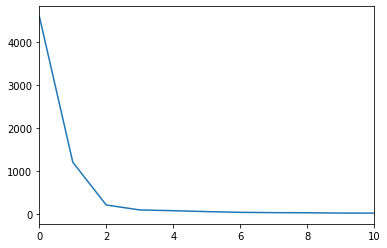

In [280]:
plt.plot(l2)
plt.xlim(0,10)

In [281]:
modes=525
UU=u2[:,0:modes]
VV=v2t.T[:,0:modes]
A=u1.data@UU
u_res=xr.DataArray(A@UU.T,coords=u1.coords)
B=v1.data@VV
AA=np.linalg.pinv(B).T@np.diag(l1[0:modes]).T
v_res=xr.DataArray(B@VV.T,coords=v1.coords)
u_est=xr.DataArray(AA@UU.T,coords=u1.coords)

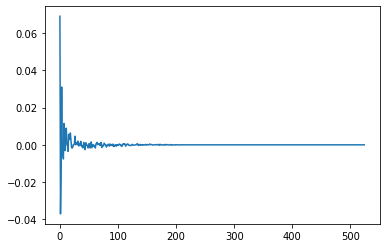

In [282]:
plt.plot(np.mean(B,axis=0))

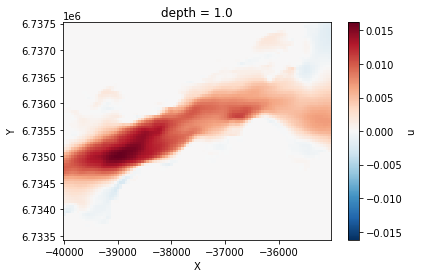

In [283]:
u1.unstack('z').mean(dim='time').plot()

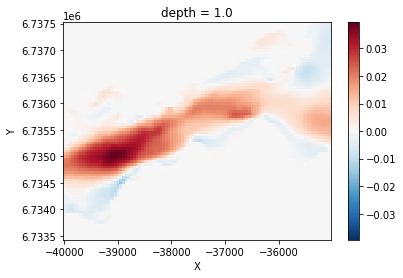

In [284]:
u_est.unstack('z').mean(dim='time').plot()

In [190]:
np.shape(v2t)

(8200, 8200)

In [7]:
tmp=data.isel(depth=0).stack(z=['Y','X'])
tmp=tmp.where(tmp.land_binary_mask==0, drop=True)


<xarray.Dataset>
Dimensions:           (time: 1501, z: 28375)
Coordinates:
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
  * z                 (z) MultiIndex
  - Y                 (z) float64 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X                 (z) float64 -4.124e+04 -4.119e+04 ... -3.214e+04
Data variables:
    u                 (time, z) float32 0.0 0.0 0.0 ... -0.02036 -0.003527
    v                 (time, z) float32 0.0 0.0 0.0 ... 0.089 0.06619 0.02443
    h                 (z) float32 23.12 33.01 46.57 61.09 ... 58.12 58.02 58.58
    projection_stere  (z) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    land_binary_mask  (z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [41]:
tmp

<xarray.Dataset>
Dimensions:           (time: 1501, z: 28375)
Coordinates:
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
  * z                 (z) MultiIndex
  - Y                 (z) float64 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X                 (z) float64 -4.124e+04 -4.119e+04 ... -3.214e+04
Data variables:
    u                 (time, z) float32 0.0 0.0 0.0 ... -0.02036 -0.003527
    v                 (time, z) float32 0.0 0.0 0.0 ... 0.089 0.06619 0.02443
    h                 (z) float32 23.12 33.01 46.57 61.09 ... 58.12 58.02 58.58
    projection_stere  (z) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    land_binary_mask  (z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [42]:
data_coarse=data.isel(depth=0,Y=slice(0,400,8),X=slice(0,200,8))
data_coarse=data_coarse.stack(z=['Y','X'])
data_coarse=data_coarse.where(data_coarse.land_binary_mask==0, drop=True)
data_coarse

<xarray.Dataset>
Dimensions:           (time: 1501, z: 454)
Coordinates:
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
  * z                 (z) MultiIndex
  - Y                 (z) float64 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X                 (z) float64 -4.104e+04 -4.064e+04 ... -3.224e+04
Data variables:
    u                 (time, z) float32 0.0 0.0 0.0001086 ... -0.01945 -0.01627
    v                 (time, z) float32 0.0 0.0 0.0002551 ... 0.01437 0.1182
    h                 (z) float32 73.4 10.98 45.86 23.22 ... 29.78 16.75 56.3
    projection_stere  (z) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    land_binary_mask  (z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [15]:
u_coarse=data_coarse.u.interpolate_na(dim='time')
u_coarse=u_coarse-u_coarse.mean(dim='time')
v_coarse=data_coarse.v.interpolate_na(dim='time')
v_coarse=v_coarse-v_coarse.mean(dim='time')

In [16]:
np.isnan(v_coarse).sum()

<xarray.DataArray 'v' ()>
array(0)
Coordinates:
    depth    float32 1.0

In [17]:
data_stacked=data.isel(depth=0).stack(z=['Y','X'])
data_stacked=data_stacked.where(data_stacked.land_binary_mask==0, drop=True)
u_fine=data_stacked.u.interpolate_na(dim='time')
u_fine=u_fine-u_fine.mean(dim='time')
v_fine=data_stacked.v.interpolate_na(dim='time')
v_fine=v_fine-v_fine.mean(dim='time')


In [43]:
np.shape(u_fine)

(1501, 28375)

In [47]:
Cu=u_fine.data.T@u_fine.data

MemoryError: Unable to allocate 3.00 GiB for an array with shape (28375, 28375) and data type float32

In [19]:
vel_fine=np.concatenate((u_fine,v_fine),axis=1)
vel_coarse=np.concatenate((u_coarse,v_coarse),axis=1)

In [20]:
vel_coarse

array([[ 0.00000000e+00,  0.00000000e+00,  1.20929151e-04, ...,
        -3.98178305e-03, -2.26855464e-03,  1.84790611e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.06203852e-05, ...,
        -1.67757273e-04, -8.23757052e-03, -8.38354602e-03],
       [ 0.00000000e+00,  0.00000000e+00, -1.02626866e-04, ...,
        -2.72987178e-03,  5.59555460e-03, -1.63549617e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -5.01243157e-05, ...,
        -1.43436599e-04,  2.53369324e-02,  1.00108698e-01],
       [ 0.00000000e+00,  0.00000000e+00, -6.36391051e-05, ...,
        -3.58514907e-03,  2.17907541e-02,  9.24086869e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.93456708e-06, ...,
        -3.97800002e-03,  9.21225734e-03,  5.92405014e-02]], dtype=float32)

In [21]:
C=vel_coarse.T@vel_fine
np.shape(C)

(908, 56750)

In [40]:
u,l,vt=np.linalg.svd(C)

MemoryError: Unable to allocate 24.0 GiB for an array with shape (56750, 56750) and data type float64

In [22]:
U,L,VT=randomized_svd(C,30,random_state=0)

In [23]:
A=vel_coarse.data@U
B=vel_fine.data@VT.T
B_est=np.linalg.pinv(A.T)@np.diag(L)

In [24]:
vel1c=A@U.T
vel1f=B@VT
vel1e=B_est@VT

In [25]:
def my_split(inarr, coords):
    tmp=np.split(inarr,2,axis=1)
    u=xr.DataArray(tmp[0],coords=coords)
    v=xr.DataArray(tmp[1],coords=coords)
    return u,v

In [26]:
u1c,v1c=my_split(vel1c,coords=u_coarse.coords)
u1f,v1f=my_split(vel1f,coords=u_fine.coords)
u1e,v1e=my_split(vel1e,coords=u_fine.coords)

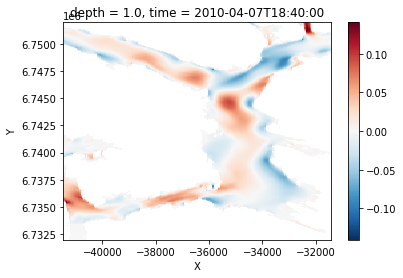

In [27]:
v1f.isel(time=150).unstack('z').plot()

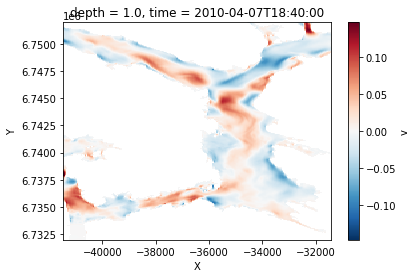

In [28]:
v_fine.isel(time=150).unstack('z').plot()

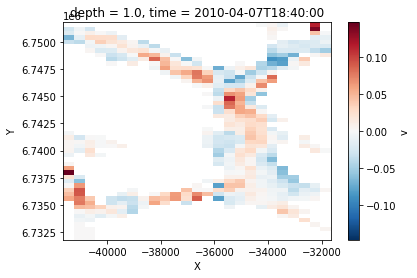

In [29]:
v_coarse.isel(time=150).unstack('z').plot()

In [30]:
u_test=u_coarse.isel(time=u_coarse.time.dt.month.isin(6))
v_test=v_coarse.isel(time=v_coarse.time.dt.month.isin(6))
uu=u_fine.isel(time=u_fine.time.dt.month.isin(6))
vel_test=np.concatenate((u_test,v_test),axis=1)
Atest=vel_test@U
Btest=np.linalg.pinv(Atest.T)@np.diag(L)
vel1test=Btest@VT
u1test,v1test=my_split(vel1test,uu.coords)

(<matplotlib.image.AxesImage at 0x7fd1619a9d90>,
 <matplotlib.colorbar.Colorbar at 0x7fd16199edc0>)

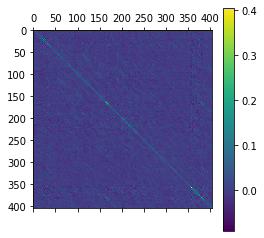

In [39]:
plt.matshow(np.linalg.pinv(Atest.T)@Atest.T),plt.colorbar()

In [37]:
print(u1test.isel(time=100).time.values)
print(uu.isel(time=100).time.values)

2010-06-08T09:46:40.000000000
2010-06-08T09:46:40.000000000


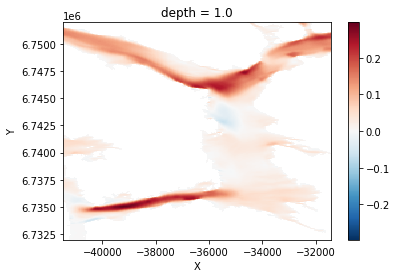

In [33]:
u1test.unstack('z').mean(dim='time').plot()

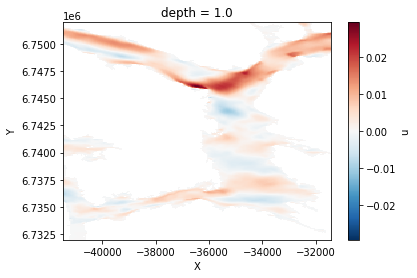

In [34]:
uu.unstack('z').mean(dim='time').plot()

In [330]:
# Select only May and surface
June=data.isel(time=data.time.dt.month.isin(6),depth=0)
April=data.isel(time=data.time.dt.month.isin(4),depth=1)

In [368]:
np.isnan(April.u).sum()

<xarray.DataArray 'u' ()>
array(0)
Coordinates:
    depth    float32 3.0

In [332]:
June_stacked=June.stack(z=('Y','X'))
April_stacked=April.stack(z=('Y','X'))

In [333]:
data6=June_stacked.where(June_stacked.land_binary_mask==0, drop=True)
data4=April_stacked.where(April_stacked.land_binary_mask==0, drop=True)
data4

<xarray.Dataset>
Dimensions:           (time: 405, z: 28375)
Coordinates:
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-04-01T00:53:20 ... 2010-04-3...
  * z                 (z) MultiIndex
  - Y                 (z) float64 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X                 (z) float64 -4.124e+04 -4.119e+04 ... -3.214e+04
Data variables:
    u                 (time, z) float32 0.0 0.0 0.0 ... 0.002662 0.003315
    v                 (time, z) float32 0.0 0.0 0.0 ... 0.01941 0.02072 0.02232
    h                 (z) float32 23.12 33.01 46.57 61.09 ... 58.12 58.02 58.58
    projection_stere  (z) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    land_binary_mask  (z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [334]:
data_coarse=data6.isel(z=slice(0,28375,1000)).dropna(dim='time')
test_coarse=data4.isel(z=slice(0,28375,1000)).dropna(dim='time')

In [335]:
u_fine=data6.u-data6.u.mean(dim='time')
u_coarse=data_coarse.u-data_coarse.u.mean(dim='time')
u_test=test_coarse.u-test_coarse.u.mean(dim='time')

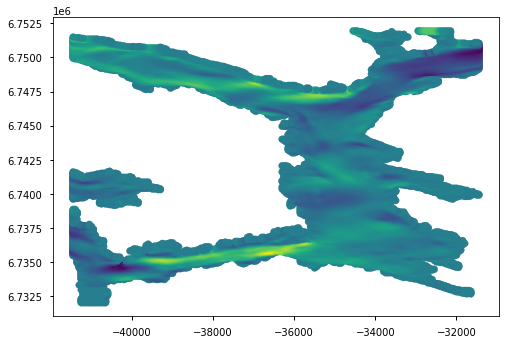

In [320]:
plt.scatter(x=u_fine.isel(time=100).X,y=u_fine.isel(time=100).Y,c=u_fine.isel(time=100))

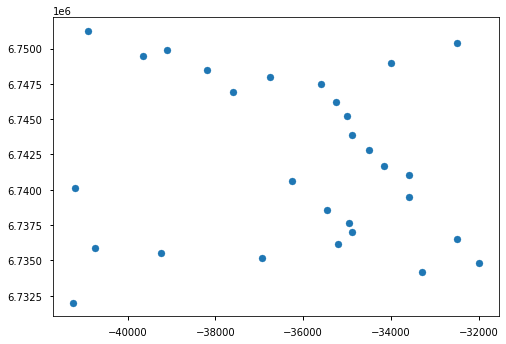

In [369]:
plt.scatter(x=u_test.X,y=u_test.Y)

In [336]:
C=u_coarse.data.T@u_fine.data

In [337]:
U,L,VT=randomized_svd(C,150,random_state=0)

In [324]:
A=u_coarse.data@U
B_est=np.linalg.pinv(A.T)@np.diag(L)

In [357]:
A_test=u_test.data@U
B_test=np.linalg.pinv(A_test.T)@np.diag(L)

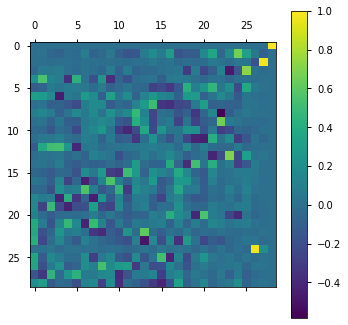

In [403]:
plt.matshow(U)
plt.colorbar()

In [358]:
B=u_fine.data@VT.T


In [380]:
u_test.max()

<xarray.DataArray 'u' ()>
array(0.18218964, dtype=float32)
Coordinates:
    depth    float32 3.0

In [406]:
u_est=xr.DataArray(B_test@VT,coords=data4.coords)
u_est.max()

<xarray.DataArray ()>
array(250648.52, dtype=float32)
Coordinates:
    depth    float32 3.0

In [360]:
data4.u

<xarray.DataArray 'u' (time: 405, z: 28375)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.00401845,
        -0.0010604 , -0.00147808],
       [ 0.        ,  0.        ,  0.        , ...,  0.02109829,
         0.01604008,  0.00644687],
       [ 0.        ,  0.        ,  0.        , ...,  0.00564489,
         0.01245364,  0.00683325],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.01176799,
        -0.00069676,  0.00210808],
       [ 0.        ,  0.        ,  0.        , ..., -0.01063677,
        -0.00607965, -0.00177541],
       [ 0.        ,  0.        ,  0.        , ..., -0.00461948,
         0.00266164,  0.00331459]], dtype=float32)
Coordinates:
    depth    float32 3.0
  * time     (time) datetime64[ns] 2010-04-01T00:53:20 ... 2010-04-30T23:06:40
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Attributes:
    units:          meter second-1
    time:           ocean_time
    field:          u-velocity, scalar, series
    grid_mapping:   projection_stere
    long_name:      Sea water x velocity
    standard_name:  x_sea_water_velocity
    coordinates:    lon lat

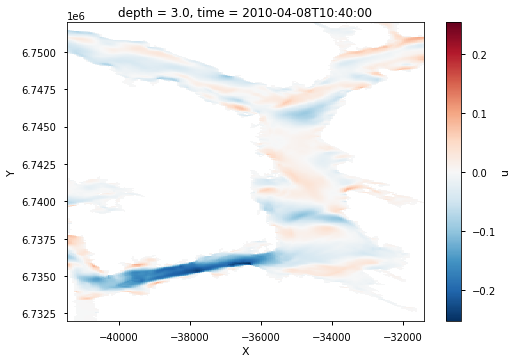

In [373]:
(data4.u-data4.u.mean(dim='time')).isel(time=100).unstack('z').plot()

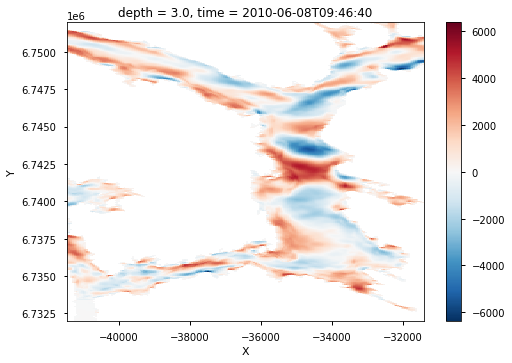

In [362]:
u_est.unstack('z').isel(time=100).plot()

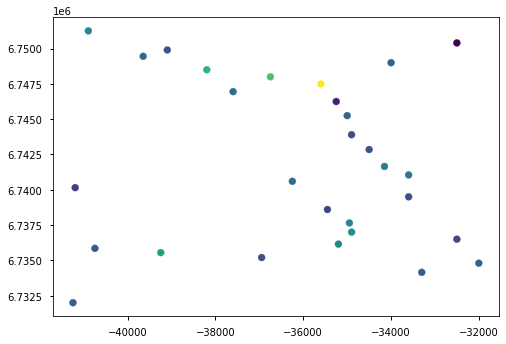

In [329]:
plt.scatter(x=u_coarse.X,y=u_coarse.Y,c=u_coarse.isel(time=100))

In [9]:

June_stacked['u_mean']=June_stacked.u.mean(dim='time')
June_stacked['v_mean']=June_stacked.v.mean(dim='time')

Do the tide extraction

In [ ]:
do_tide=False

if do_tide:
    May_stacked_wet=May_stacked.where(May_stacked.land_binary_mask==0).dropna(dim='z')
    tide=my_tide(May_stacked_wet)
else:
    tide=xr.open_dataset('Data/tide.nc').load()
    tide.close()


or read the file


In [10]:
res=my_svd_randomized(June,uname='u',vname='v',N=30)


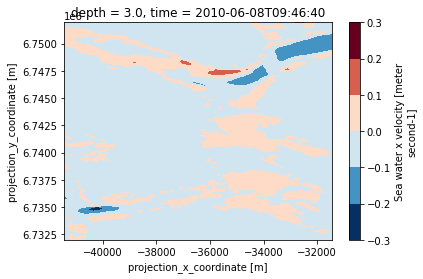

In [24]:
res.u.isel(time=100).plot.contourf()

In [72]:
focus=res.sel(Y=slice(6733400,6737500),X=slice(-40000,-35000))
focus_stack=focus.stack(z=['Y','X'])


In [74]:
cru=xr.corr(focus_stack.u_pcs,focus_stack.u,dim='time')
crv=xr.corr(focus_stack.v_pcs,focus_stack.v,dim='time')


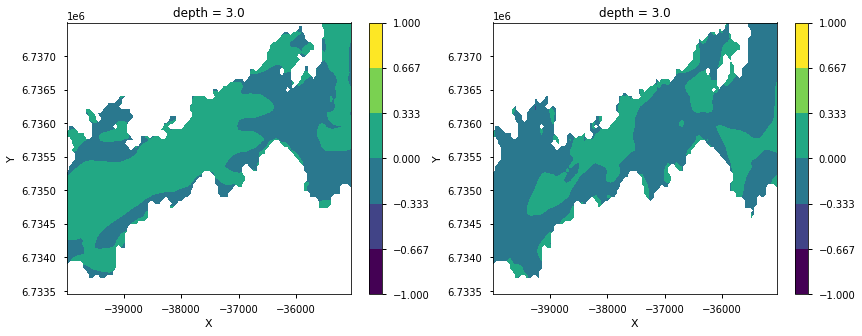

In [81]:
style.use('seaborn-notebook')
mode=11
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=False, sharex=True,  figsize=(14, 5))
cru.isel(mode=mode).unstack('z').plot.contourf(vmin=-1, vmax=1,ax=ax0)
crv.isel(mode=mode).unstack('z').plot.contourf(vmin=-1, vmax=1,ax=ax1)



In [91]:
res_focus=my_svd_randomized(focus.drop(['u_eigen','u_pcs','v_pcs','u_eofs','v_eofs']),uname='u',vname='v',N=30)
res_focus

<xarray.Dataset>
Dimensions:           (Y: 82, time: 405, X: 100, mode: 30)
Coordinates:
  * Y                 (Y) float64 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
  * X                 (X) float32 -3.999e+04 -3.994e+04 ... -3.504e+04
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-06-01 ... 2010-06-30T22:13:20
Dimensions without coordinates: mode
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.01112 -0.01352
    v                 (time, Y, X) float32 0.0 0.0 0.0 ... 0.01396 0.01355
    h                 (Y, X) float32 0.0 0.0 0.0 0.0 ... 127.2 151.3 174.5 197.2
    projection_stere  float32 9.969e+36
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    u_eigen           (mode) float32 2.267e+03 575.4 122.4 ... 3.333 3.171 2.929
    u_pcs             (time, mode) float32 4.602 -0.2694 ... 0.2064 0.05262
    v_pcs             (time, mode) float32 2.275 0.2098 ... 0.122 -0.02172
    u_eofs            (mode, Y, X) float32 nan nan nan ... 0.02199 0.02705
    v_eofs            (mode, Y, X) float32 nan nan nan ... -0.03837 -0.03462
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

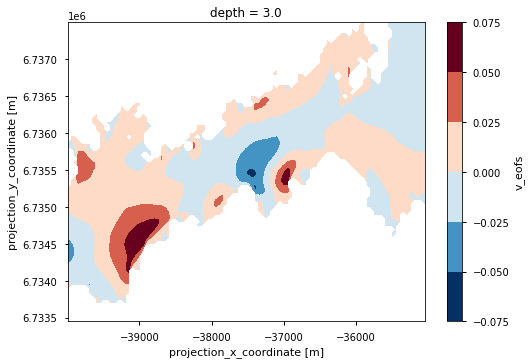

In [103]:
res_focus.v_eofs.isel(mode=1).plot.contourf()

In [104]:
cru_foc=xr.corr(res_focus.u_pcs,res_focus.u,dim='time')
crv_foc=xr.corr(res_focus.v_pcs,res_focus.v,dim='time')


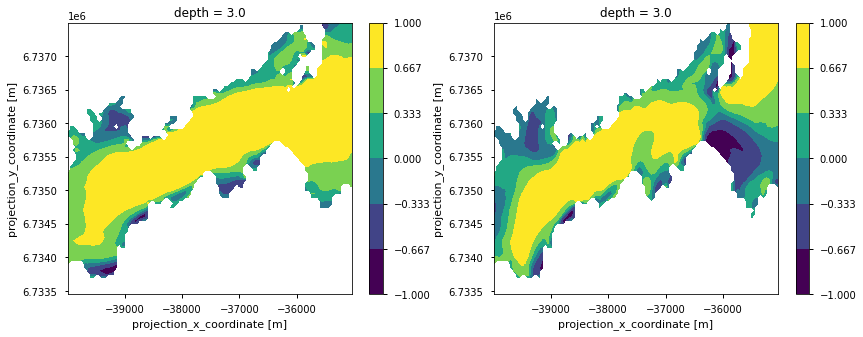

In [121]:
style.use('seaborn-notebook')
mode=0
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=False, sharex=True,  figsize=(14, 5))
cru_foc.isel(mode=mode).plot.contourf(vmin=-1, vmax=1,ax=ax0)
crv_foc.isel(mode=mode).plot.contourf(vmin=-1, vmax=1,ax=ax1)


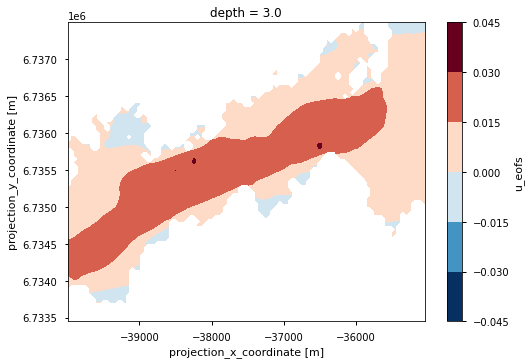

In [117]:
focus.u_eofs.isel(mode=0).plot.contourf()

In [132]:
res_focus

<xarray.Dataset>
Dimensions:           (Y: 82, time: 405, X: 100, mode: 30)
Coordinates:
  * Y                 (Y) float64 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
  * X                 (X) float32 -3.999e+04 -3.994e+04 ... -3.504e+04
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-06-01 ... 2010-06-30T22:13:20
Dimensions without coordinates: mode
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.01112 -0.01352
    v                 (time, Y, X) float32 0.0 0.0 0.0 ... 0.01396 0.01355
    h                 (Y, X) float32 0.0 0.0 0.0 0.0 ... 127.2 151.3 174.5 197.2
    projection_stere  float32 9.969e+36
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    u_eigen           (mode) float32 2.267e+03 575.4 122.4 ... 3.333 3.171 2.929
    u_pcs             (time, mode) float32 4.602 -0.2694 ... 0.2064 0.05262
    v_pcs             (time, mode) float32 2.275 0.2098 ... 0.122 -0.02172
    u_eofs            (mode, Y, X) float32 nan nan nan ... 0.02199 0.02705
    v_eofs            (mode, Y, X) float32 nan nan nan ... -0.03837 -0.03462
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [131]:
mode=4
cruv=xr.corr(res_focus.u_pcs.isel(mode=mode),res_focus.v_pcs.isel(mode=mode),dim='time')
cruv#.plot.contourf(vmin=-1, vmax=1)




<xarray.DataArray ()>
array(0.84042611)
Coordinates:
    depth    float32 3.0

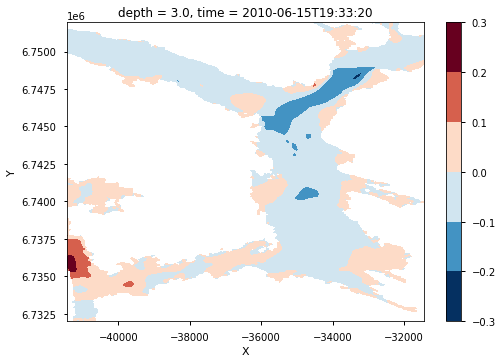

In [54]:

res.v_eofs.dot(res.v_pcs).unstack('z').isel(time=200).plot.contourf()

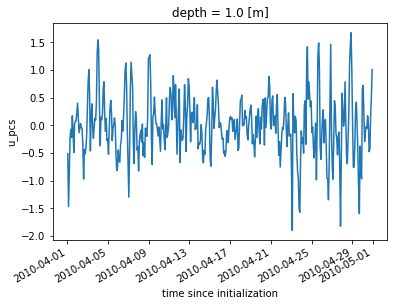

In [72]:
res.unstack('z').direction.isel(mode=19).plot()

In [156]:
res.Y.min()

<xarray.DataArray 'Y' ()>
array(6731999.)
Coordinates:
    depth    float32 3.0

In [162]:
focused=res.where(((res.Y <= 6737999) & (res.X > -40000)&(res.X < -35000)),drop=True)

In [167]:
focused_stacked=focused.stack(z=['Y','X'])

In [171]:
work=focused_stacked.where(focused_stacked.land_binary_mask==0,drop=True)

In [189]:
work.u.std(dim='time').min()

<xarray.DataArray 'u' ()>
array(0., dtype=float32)
Coordinates:
    depth    float32 3.0

In [204]:
C=np.dot(((work.u-work.u.mean(dim='time'))/(1e-9+work.u.std(dim='time'))).T,
(work.u-work.u.mean(dim='time'))/(1e-9+work.u.std(dim='time')))



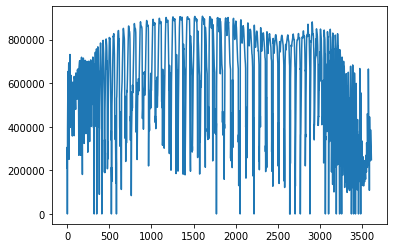

In [214]:
plt.plot(np.sum(np.abs(C),axis=1))

In [206]:
coor=np.where(C==np.amax(C))
coor[0]

array([2822])

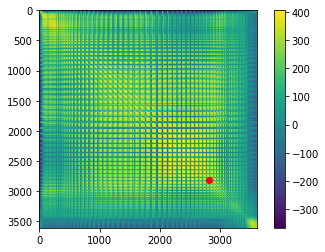

In [207]:
plt.imshow(C)
plt.plot(coor[0],coor[1],'ro')
plt.colorbar()

Text(0.5, 1.0, 'Residue')

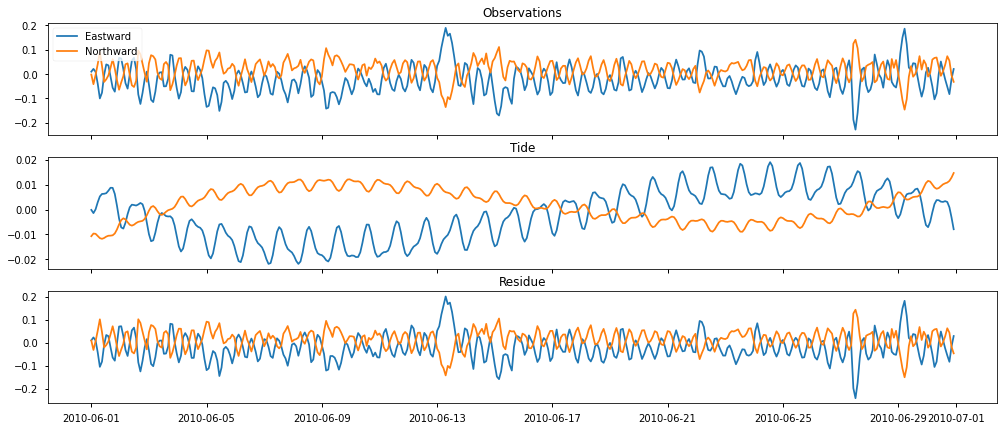

In [35]:
from matplotlib import style

style.use('seaborn-notebook')
t=num2date(time)
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=False, sharex=True,  figsize=(17, 7))

ax0.plot(t, tmpu.u, label='Eastward')
ax0.plot(t, tmpu.v, label='Northward')
ax0.legend(numpoints=1, loc='upper left')
ax0.set_title('Observations')


ax1.plot(t, tide['u'] )
ax1.plot(t, tide['v'])
ax1.set_title('Tide')
#ax1.legend(numpoints=1, loc='upper left')

ax2.plot(t, tmpu.u-tide['u'])
ax2.plot(t, tmpu.v-tide['v'])
ax2.set_title('Residue')

In [172]:
type(coef)
from pickle import dump

dump(coef,open('test.pkl','wb'))

utide.utilities.Bunch

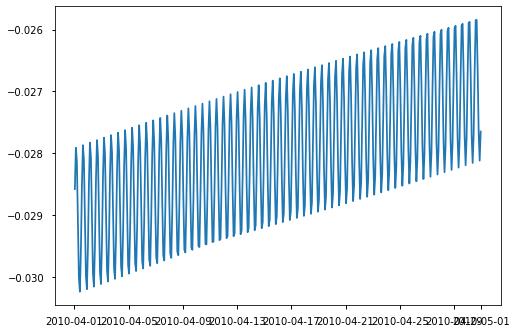

In [356]:
plt.plot(num2date(tide.t_in),tide.v)

In [34]:
U,L,Vh = randomized_svd(C,20)

/Users/guttorm/Documents/GitHub/FACTS/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:370: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


In [375]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(tmpu.u,)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [173]:
from pickle import dump

dump(coef,open('test.pkl','wb'))

In [43]:
res=eofs_GA(May_stacked,neofs=None)
res['land_binary_mask']=May['land_binary_mask']
res

NotImplementedError: isna is not defined for MultiIndex

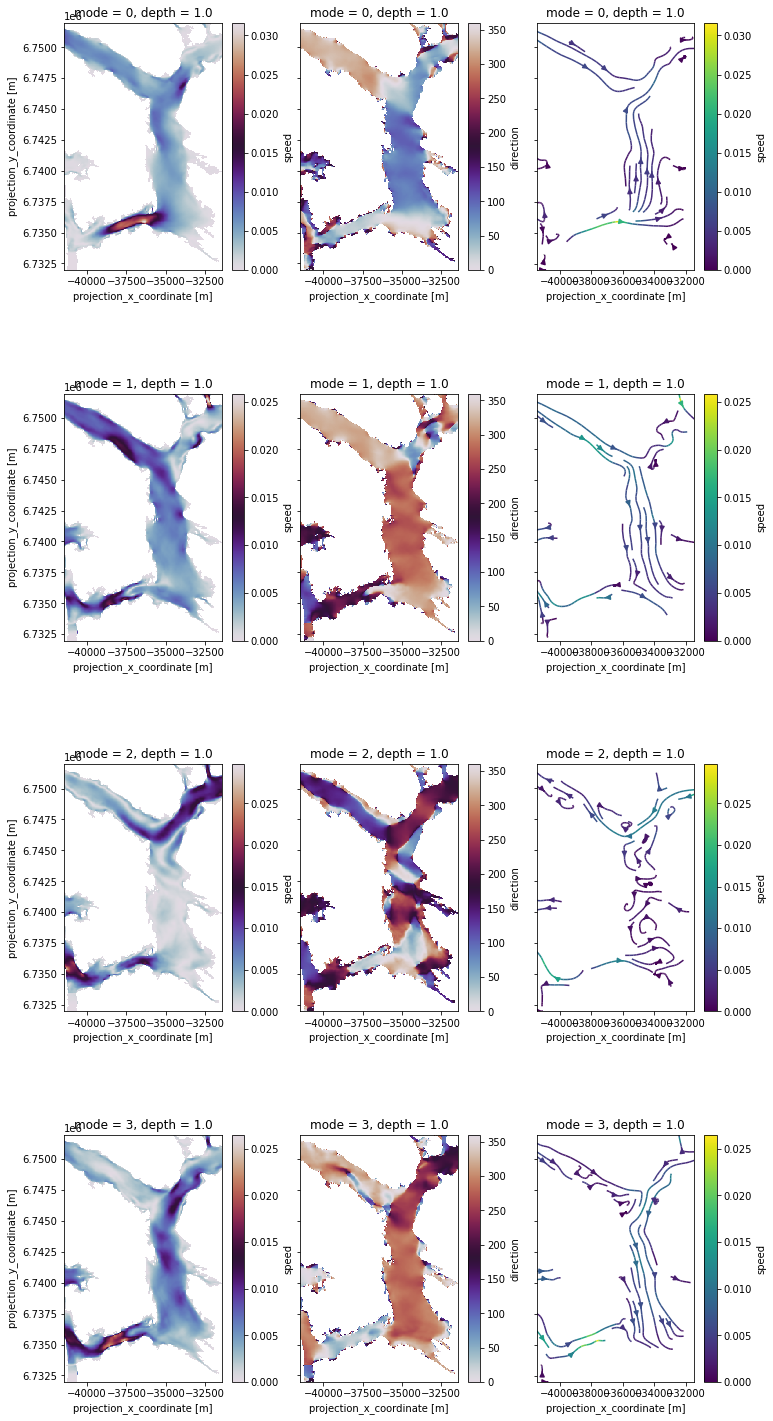

In [27]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 25))
plt.subplots_adjust(hspace=0.5)
axes=axs.ravel()
for mode in np.arange(4):
    res['speed'].where(res.land_binary_mask==0).isel(mode=mode).plot(ax=axes[3*mode],cmap='twilight')
    
    res['direction'].where(res.land_binary_mask==0).isel(mode=mode).plot(cmap='twilight',ax=axes[3*mode+1])
    res.isel(mode=mode).where(res.land_binary_mask==0).plot.streamplot(x='X',y='Y' ,u='u', v='v',hue='speed',ax=axes[3*mode+2])
    axs[mode][1].set_ylabel('')
    axs[mode][1].set_yticklabels('')
    axs[mode][2].set_ylabel('')
    axs[mode][2].set_yticklabels('')


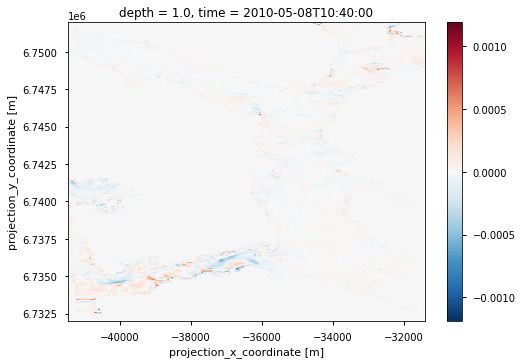

In [99]:
(May.isel(depth=0).u.differentiate(coord='X')+May.isel(depth=0).v.differentiate(coord='Y')).isel(time=100).plot()


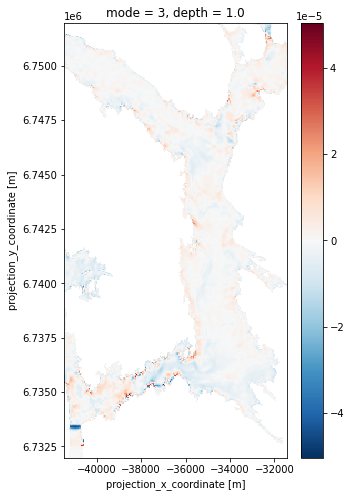

In [77]:
tmp=res.isel(mode=3)
(tmp.u.differentiate(coord='X')+tmp.v.differentiate(coord='Y')).where(res.land_binary_mask==0).plot(figsize=(5,8))


In [90]:
tmp[1]

<AxesSubplot:title={'center':'mode = 1, depth = 3.0'}, xlabel='projection_x_coordinate [m]', ylabel='projection_y_coordinate [m]'>

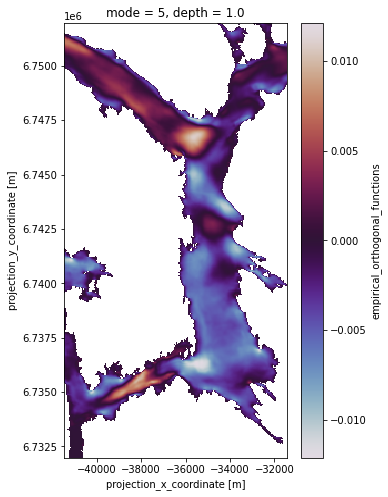

In [50]:
res['u'].where(res.land_binary_mask==0).isel(mode=5).plot(cmap='twilight',figsize=(5,8))

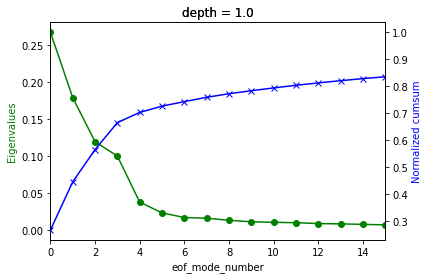

In [48]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
(res.eigenvals/res.eigenvals.sum()).plot(marker='o',color='g',ax=ax1)
(res.eigenvals.cumsum()/res.eigenvals.sum()).plot(color='b',marker='x',ax=ax2)

ax1.set_ylabel('Eigenvalues', color='g')
ax2.set_ylabel('Normalized cumsum', color='b')
plt.xlim(0,15)
plt.show()

(0.0, 5.0)

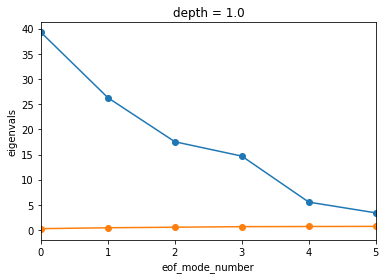

In [31]:
res.eigenvals.plot(marker='o')
(res.eigenvals.cumsum()/res.eigenvals.sum()).plot(marker='o')
plt.xlim(0,5)

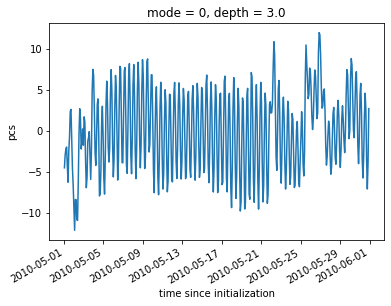

In [18]:
mode=0
res.pcs.isel(mode=mode).plot()

TypeError: __call__() takes 1 positional argument but 2 were given

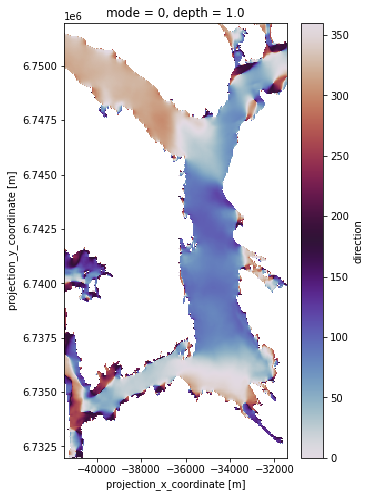

In [44]:
mode=10
res.direction.where(res.land_binary_mask==0).isel(mode=mode).plot()

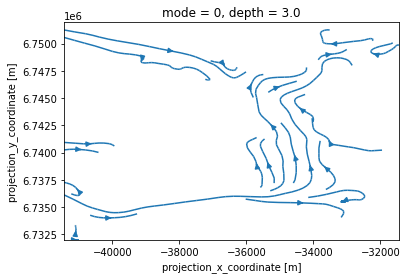

In [20]:
res.isel(mode=mode).where(res.land_binary_mask==0).plot.streamplot(x='X',y='Y' ,u='u', v='v')

In [113]:
help(xr.streamplot)

AttributeError: module 'xarray' has no attribute 'streamplot'

In [115]:
mode=4
tmp=(res.isel(mode=mode).pcs*res.isel(mode=mode).eigenvals)
tmp


<xarray.DataArray (time: 418)>
array([ 2.51191559e+01,  3.43576698e+01,  2.70350609e+01, -6.90878868e+00,
       -1.74213657e+01, -1.40487537e+01, -1.97940865e+01,  1.00656357e+01,
       -3.73587632e+00, -3.60380381e-01, -2.35856175e+00, -1.31972599e+00,
        4.25410423e+01,  7.04083099e+01,  4.00344772e+01, -5.73251247e+00,
       -1.60317554e+01, -1.57020779e+01, -1.47514153e+01, -1.57096205e+01,
       -1.64089279e+01, -1.43239803e+01, -1.14165907e+01, -2.42575722e+01,
       -5.26303368e+01,  3.73313560e+01,  5.59709435e+01,  9.72277546e+00,
       -1.40220869e+00, -5.83586979e+00, -5.90118408e+00, -3.76218820e+00,
        1.64434147e+01,  3.29918137e+01, -2.25301094e+01, -2.55837078e+01,
       -1.79004879e+01, -4.56511650e+01, -1.64342537e+01,  1.59816754e+00,
        7.08576250e+00,  3.00996566e+00,  6.32103741e-01,  1.37846696e+00,
        4.23830843e+00,  7.44553423e+00,  6.48577070e+00,  1.54397130e-01,
        4.01143951e+01, -1.38502455e+01,  1.22235184e+01, -7.12136936e+00,
       -7.84985685e+00, -1.17526674e+01, -1.27301912e+01, -1.05963640e+01,
       -1.13587770e+01, -8.01495266e+00, -3.98594689e+00, -1.42811193e+01,
       -2.55945563e+00, -1.58297396e+01,  2.40459251e+01,  8.79130363e+00,
        6.99451160e+00,  1.59862947e+00, -1.75135958e+00, -1.64975250e+00,
       -6.14190054e+00, -4.94580603e+00,  9.07736897e-01, -2.43802503e-01,
       -9.99710941e+00,  3.53043228e-01, -1.88284302e+01, -5.07494259e+00,
        2.14468288e+00,  2.38385424e-01, -7.97924566e+00, -4.85249901e+00,
...
        8.04285336e+00,  1.99379654e+01,  5.24168789e-01,  1.34703531e+01,
        4.16118956e+00,  1.04785514e+00, -2.66268682e+00, -2.62183208e+01,
       -5.69773674e+01, -4.00022507e+00,  2.31581593e+01,  1.88279190e+01,
        1.02514009e+01,  5.02461100e+00,  4.92792559e+00,  8.78254700e+00,
        1.20835199e+01,  1.27113161e+01,  1.04325953e+01,  6.80696106e+00,
        4.71250010e+00,  2.04208779e+00, -4.82542574e-01, -3.20232105e+00,
       -8.65886688e+00, -1.23804083e+01, -1.14530964e+01, -5.82128048e+00,
        6.08637631e-01,  2.64530611e+00,  2.94658560e-02, -3.36639309e+00,
       -5.08620930e+00, -5.91906118e+00, -1.98346651e+00, -6.93928838e-01,
       -3.81162310e+00, -1.08745260e+01, -1.19807243e+01, -1.07903414e+01,
       -4.38737202e+00,  8.65319633e+00, -2.78511524e+00, -2.76620502e+01,
        6.76414633e+00, -6.35042000e+00,  6.65179312e-01, -4.08597660e+00,
       -2.30468065e-02, -2.65089840e-01,  8.47981071e+00, -1.30473433e+01,
       -2.62149620e+01,  1.93823552e+00,  8.58087540e+00,  7.05244827e+00,
        6.99304962e+00,  6.60602951e+00, -5.28119326e-01,  1.10472040e+01,
        1.15295839e+01,  1.00335531e+01, -9.47922826e-01,  1.35852709e+01,
        2.80311370e+00, -5.82450247e+00,  2.05472541e+00,  1.98660803e+00,
       -5.46554041e+00, -8.06682873e+00,  1.21224232e+01,  1.92555122e+01,
        6.95254230e+00, -3.38021708e+00, -7.48701620e+00, -4.07501364e+00,
       -1.37264929e+01, -4.67563725e+00], dtype=float32)
Coordinates:
    mode     int64 4
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-05-01T00:53:20 ... 2010-05-31T22:13:20

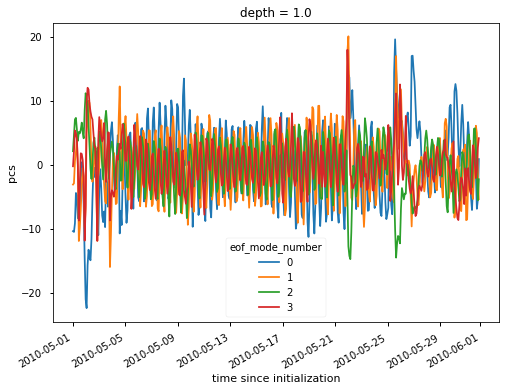

In [101]:
res.pcs.isel(mode=[0,1,2,3]).plot.line(x='time')

In [22]:
res

<xarray.Dataset>
Dimensions:           (mode: 10, Y: 400, X: 201, time: 1501)
Coordinates:
  * mode              (mode) int64 0 1 2 3 4 5 6 7 8 9
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (mode, Y, X) float32 2.214e-16 4.443e-16 ... 0.0 0.0
    v                 (mode, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    eigenvals         (mode) float32 28.59 19.41 14.78 ... 1.008 0.9224 0.8579
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    speed             (mode, Y, X) float32 2.214e-16 4.443e-16 ... 0.0 0.0
    direction         (mode, Y, X) float32 90.0 90.0 270.0 90.0 ... 0.0 0.0 0.0
    pcs               (time, mode) float32 -12.16 -2.491 -1.415 ... nan nan nan

In [45]:
date2num(res.time)

array([14730.03703704, 14730.11111111, 14730.18518519, 14730.25925926,
       14730.33333333, 14730.40740741, 14730.48148148, 14730.55555556,
       14730.62962963, 14730.7037037 , 14730.77777778, 14730.85185185,
       14730.92592593, 14731.        , 14731.07407407, 14731.14814815,
       14731.22222222, 14731.2962963 , 14731.37037037, 14731.44444444,
       14731.51851852, 14731.59259259, 14731.66666667, 14731.74074074,
       14731.81481481, 14731.88888889, 14731.96296296, 14732.03703704,
       14732.11111111, 14732.18518519, 14732.25925926, 14732.33333333,
       14732.40740741, 14732.48148148, 14732.55555556, 14732.62962963,
       14732.7037037 , 14732.77777778, 14732.85185185, 14732.92592593,
       14733.        , 14733.07407407, 14733.14814815, 14733.22222222,
       14733.2962963 , 14733.37037037, 14733.44444444, 14733.51851852,
       14733.59259259, 14733.66666667, 14733.74074074, 14733.81481481,
       14733.88888889, 14733.96296296, 14734.03703704, 14734.11111111,
      

In [46]:

coef = solve(date2num(res.time), y, lat=60.0, method='robust',Rayleigh_min=0.9)#, constit=['M2'])#,nodal=True, rend=True, method='robust', conf_int='linear', Rayleigh_min=0.95)

tide = reconstruct(date2num(res.time), coef)

coef.keys()

solve: matrix prep ... solution ... done.
prep/calcs ... done.


dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'rf', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn', 'PE', 'SNR'])